### Importing libraries and loading digits

Shape dataset is (1797, 64) and each image is 8x8

Shape: (1797, 64)


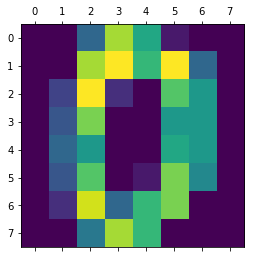

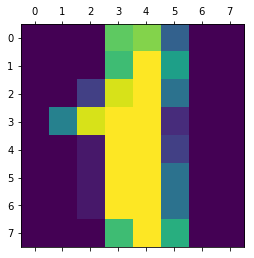

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, pairwise_distances
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

digits = load_digits(n_class=10, return_X_y=False)
print('Shape:', digits.data.shape)

plt.matshow(digits.images[0]) 
plt.matshow(digits.images[1]) 

### Utilities and helpers

In [2]:
def show_result(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    print('Accuracy score: %.8f' % accuracy_score(y_true, y_pred))
    print()
    print("Confusion Matrix")
    print(cm)

    plt.scatter(y_true, y_pred, alpha=0.25)

def train_and_test(classifier):
    classifier.fit(X_train, y_train)
    Y = classifier.predict(X_test)
    show_result(y_test, Y)
    
def find_best_k(classifier):
    parameters = {'k':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    grid_search = GridSearchCV(classifier, parameters, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

    cvres = grid_search.cv_results_
    for ms, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(int(params["k"]), ':', np.sqrt(-ms))
    
    return grid_search.best_params_["k"]

### Splitting data

In [3]:
indices = np.arange(digits.data.shape[0])
np.random.shuffle(indices)

data = digits.data[indices]
target = digits.target[indices]

(X_train, X_test, y_train, y_test) = train_test_split(digits.data, digits.target, test_size=0.2)

### Naive  kNN implementation

In [4]:
class NaiveKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k = None):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X_test):
        res = np.zeros(len(X_test))
        if self.k is None: 
            return res
        
        diff = X_test[:, np.newaxis, :] - self.X[np.newaxis, :, :]
        diff = diff ** 2
        diff = diff.sum(-1)
        diff = np.argsort(diff, axis=1)[:, :self.k]
        return np.apply_along_axis(self.__weight, 1, diff)
    
    def __weight(self, a):
        return np.bincount(self.y[a]).argmax()

### kNN with Potential Function

In [5]:
class PotentialKNNClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.X = self.__normalize(X)
        self.y = y
        self.classes = np.arange(self.y.max() + 1)
        self.gammas = np.zeros(self.X.shape[0])
        
        epsilon = 0.95
        iteration = 0
        max_score = -1
        max_gammas = np.copy(self.gammas)
        max_iterations = 50000
        
        while True:
            index = np.random.randint(0, high=self.X.shape[0], size=1)
            prediction = self.__fit(X[index])
            change = np.argwhere(prediction != self.y[index])
            if len(prediction[change]) > 0:
                self.gammas[index] = self.gammas[index] + 1
            
            if iteration % 500 == 0:
                score = self.score(X, y)
                print(iteration, ':', score, ':', self.gammas)
                
                if score > epsilon: break
                    
                if score > max_score:
                    max_score = score
                    max_gammas = np.copy(self.gammas)
                    
            if iteration > max_iterations:
                self.gammas = max_gammas
                print('Stopping at:', score, ':', self.gammas)
                break
                
            iteration += 1
                

    def predict(self, X_test):
        return self.__fit(X_test)
    
    def __normalize(self, X):
        return (X - X.mean()) / X.std()
    
    def __fit(self, X_test):
        distances = X_test[:, np.newaxis, :] - self.X[np.newaxis, :, :]
        distances = distances ** 2
        distances = distances.sum(-1)
        
        max = np.full((distances.shape[0],), -1)
        max_class = np.full((distances.shape[0],), -1)
        
        for _, c in enumerate(self.classes):
            indices = np.argwhere(self.y == c)
            
            gammas = self.gammas[indices].ravel()
            dist = distances[:, indices]
            dist = dist.reshape(dist.shape[0], dist.shape[1])
            val = self.__kernel1(dist).dot(gammas)
            
            change = np.argwhere(val > max)
            max[change] = val[change]
            max_class[change] = c

        return max_class
    
    def __kernel1(self, dist):
        dist = dist/10000
        ones = np.ones(dist.shape)
        return ones / (dist + ones)
    
    def __kernel2(self, dist):
        rad = 10000
        alpha = 1
        return np.exp(-dist/rad)/(dist + alpha)

### Weighted kNN

In [ ]:
train_and_test(PotentialKNNClassifier())

0 : 0.10160055671537926 : [0. 0. 0. ... 0. 0. 0.]
500 : 0.2609603340292276 : [1. 0. 0. ... 0. 1. 0.]
1000 : 0.47529575504523314 : [1. 0. 0. ... 0. 1. 0.]
1500 : 0.5908141962421712 : [2. 0. 1. ... 0. 1. 0.]
2000 : 0.5762004175365344 : [2. 0. 1. ... 0. 1. 1.]
2500 : 0.5859429366736256 : [2. 0. 1. ... 0. 1. 1.]
3000 : 0.7926235212247739 : [3. 0. 1. ... 0. 1. 1.]
3500 : 0.6896311760612387 : [3. 0. 1. ... 0. 1. 1.]
4000 : 0.7118997912317327 : [3. 0. 1. ... 1. 1. 1.]
4500 : 0.8016701461377871 : [3. 2. 1. ... 2. 1. 1.]
5000 : 0.6931106471816284 : [3. 2. 1. ... 2. 1. 1.]
5500 : 0.6221294363256785 : [3. 4. 1. ... 2. 2. 1.]
6000 : 0.8016701461377871 : [3. 4. 1. ... 2. 2. 1.]
6500 : 0.8705636743215032 : [3. 4. 1. ... 2. 2. 1.]
7000 : 0.7390396659707724 : [3. 4. 1. ... 2. 2. 1.]
7500 : 0.5880306193458594 : [3. 4. 1. ... 3. 3. 1.]
8000 : 0.8580375782881002 : [3. 4. 1. ... 3. 3. 1.]
8500 : 0.7543493389004872 : [3. 4. 1. ... 3. 3. 1.]
9000 : 0.837160751565762 : [3. 4. 1. ... 3. 3. 1.]
9500 : 0.853166

### Outputing naive KNN classifier

In [ ]:
k = 3
train_and_test(NaiveKNNClassifier(k))

### Using KNeighborsClassifier from sklearn to test data

In [ ]:
train_and_test(KNeighborsClassifier(k))